In [1]:
import sys
from typing import List, Tuple, Set
import heapq

import numpy as np
import pandas as pd

sys.path.append('../..')
from utils import set_seed, plot_graph, plot_shortest_path

# Set random seed for reproducibility
set_seed(42)

In [2]:
class BranchAndBoundTSP:
    """
    A class to solve the Traveling Salesman Problem (TSP) using Branch-and-Bound.
    Finds the shortest Hamiltonian cycle starting and ending at node 0.

    Attributes:
        distances (np.ndarray): Distance matrix between nodes.
        n (int): Number of nodes.
        best_cost (float): The best (minimum) cost found.
        best_path (List[Tuple[int, int]] or None): The path that achieves the best cost.
        nodes_explored (int): Number of nodes explored in the search tree.
    """

    def __init__(self, distances_array: np.ndarray):
        """
        Initializes the BranchAndBoundTSP instance.

        Args:
            distances_array (np.ndarray): 2D array representing distances between nodes.
        """
        self.distances = distances_array
        self.n = len(distances_array)
        self.best_cost = float('inf')
        self.best_path = None
        self.nodes_explored = 0

    def lower_bound_mst(self, current_node: int, visited: Set[int], current_cost: float) -> float:
        """
        Computes a lower bound using the Minimum Spanning Tree (MST) heuristic.
        
        The lower bound is: current_cost + MST_cost_of_unvisited + min_edge_from_current + min_edge_to_start

        Args:
            current_node (int): The current node in the path.
            visited (Set[int]): Set of visited nodes.
            current_cost (float): Cost accumulated so far.

        Returns:
            float: Lower bound on the total cost.
        """
        if len(visited) == self.n:
            # Complete tour, add cost to return to start
            return current_cost + self.distances[current_node, 0]

        unvisited = set(range(self.n)) - visited
        
        # Calculate MST of unvisited nodes using Prim's algorithm
        mst_cost = 0
        if len(unvisited) > 1:
            mst_nodes = list(unvisited)
            in_mst = {mst_nodes[0]}
            edges = []
            
            for node in mst_nodes[1:]:
                heapq.heappush(edges, (self.distances[mst_nodes[0], node], mst_nodes[0], node))
            
            while len(in_mst) < len(mst_nodes):
                cost, u, v = heapq.heappop(edges)
                if v in in_mst:
                    continue
                mst_cost += cost
                in_mst.add(v)
                
                for node in mst_nodes:
                    if node not in in_mst:
                        heapq.heappush(edges, (self.distances[v, node], v, node))
        
        # Minimum cost edge from current node to any unvisited node
        min_out = min(self.distances[current_node, j] for j in unvisited) if unvisited else 0
        
        # Minimum cost edge from any unvisited node back to start (0)
        # If we're at the last unvisited node, this is the direct return cost
        if 0 not in visited:
            min_return = 0  # Start node not visited yet (shouldn't happen in our setup)
        else:
            min_return = min(self.distances[j, 0] for j in unvisited) if unvisited else 0
        
        return current_cost + mst_cost + min_out + min_return

    def branch_and_bound(self) -> Tuple[List[Tuple[int, int]], float, int]:
        """
        Performs branch-and-bound search to find the optimal TSP tour.

        Returns:
            Tuple[List[Tuple[int, int]], float, int]: Best path (as edges), total cost, nodes explored.
        """
        priority_queue = []
        self.nodes_explored = 0

        # Initial node: (lower_bound, current_cost, current_node, path_edges, visited_nodes)
        start_node = 0
        initial_visited = {start_node}
        initial_lb = self.lower_bound_mst(start_node, initial_visited, 0)
        
        heapq.heappush(priority_queue, (
            initial_lb,
            0.0,  # current cost
            start_node,  # current node
            tuple(),  # path edges
            frozenset([start_node])  # visited nodes
        ))

        while priority_queue:
            lower_bound_value, current_cost, current_node, path_edges, visited = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            # Prune by lower bound
            if lower_bound_value >= self.best_cost:
                continue

            # Check if tour is complete
            if len(visited) == self.n:
                # Add edge back to start
                total_cost = current_cost + self.distances[current_node, start_node]
                if total_cost < self.best_cost:
                    self.best_cost = total_cost
                    self.best_path = list(path_edges) + [(current_node, start_node)]
                continue

            # Branch: try visiting each unvisited node
            visited_set = set(visited)
            for next_node in range(self.n):
                if next_node in visited_set:
                    continue
                
                # Calculate new state
                edge_cost = self.distances[current_node, next_node]
                new_cost = current_cost + edge_cost
                new_path = path_edges + ((current_node, next_node),)
                new_visited = visited_set | {next_node}
                
                # Compute lower bound for new state
                new_lower_bound = self.lower_bound_mst(next_node, new_visited, new_cost)
                
                # Only add to queue if not pruned
                if new_lower_bound < self.best_cost:
                    heapq.heappush(priority_queue, (
                        new_lower_bound,
                        new_cost,
                        next_node,
                        new_path,
                        frozenset(new_visited)
                    ))

        return self.best_path, self.best_cost, self.nodes_explored


def solve_tsp(distances_array: np.ndarray) -> Tuple[List[Tuple[int, int]], float, int]:
    """
    Solves the Traveling Salesman Problem using Branch-and-Bound.

    Args:
        distances_array (np.ndarray): 2D array representing distances between nodes.

    Returns:
        Tuple[List[Tuple[int, int]], float, int]: Best path, total cost, and nodes explored.
    """
    solver = BranchAndBoundTSP(distances_array)
    best_path, best_cost, nodes = solver.branch_and_bound()
    return best_path, best_cost, nodes

In [3]:
# Load the fixed distance matrix from CSV using pandas
distances_df = pd.read_csv('../../data/distances.csv', header=None)
distances = distances_df.values
distances

array([[ 0, 47, 42, 17, 36, 11, 16, 48, 21, 43],
       [49,  0, 49,  9, 18, 13,  4, 30, 33, 32],
       [ 4, 21,  0, 14, 32,  1, 21, 22,  4, 46],
       [31, 44, 25,  0, 38,  2, 42, 13,  4, 46],
       [24, 48, 20, 40,  0, 43, 26, 37, 14, 39],
       [39, 12, 12, 33, 47,  0, 15,  8, 49, 20],
       [40, 12, 17, 49, 38,  8,  0,  7, 18, 32],
       [22, 18, 21, 36, 34, 41,  6,  0, 46, 48],
       [41, 29, 35, 12,  4,  4,  7, 49,  0, 16],
       [ 1, 27, 23, 23, 46, 33, 15, 21, 47,  0]])

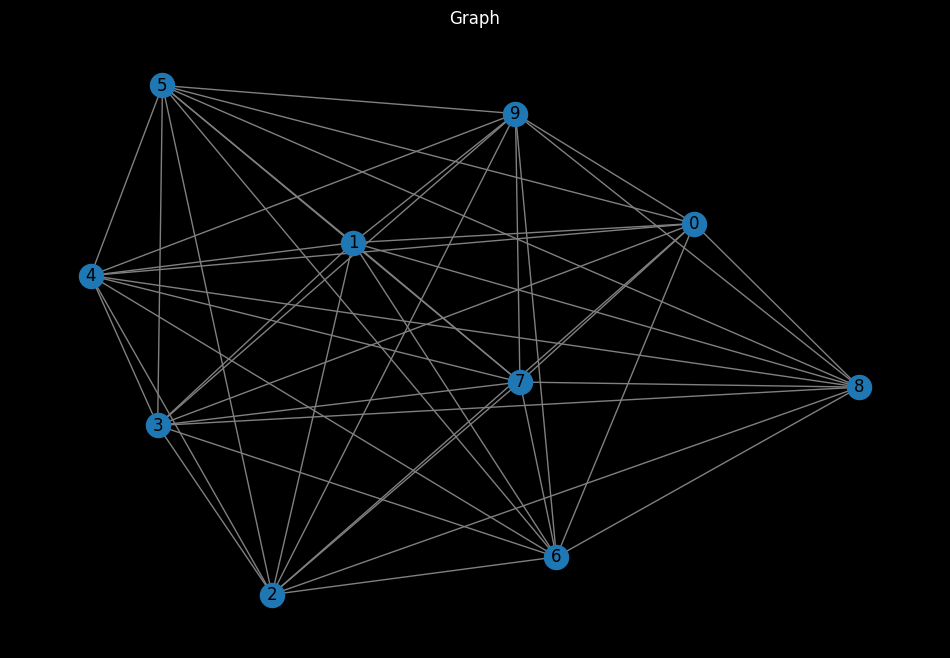

In [4]:
# Plot the graph
plot_graph(distances)

In [5]:
# Solve the TSP using Branch and Bound
best_path, best_cost, nodes_explored = solve_tsp(distances)
print(f"Best path: {best_path}")
print(f"Best cost: {best_cost}")
print(f"Nodes explored: {nodes_explored}")

Best path: [(0, 3), (3, 8), (8, 4), (4, 2), (2, 5), (5, 7), (7, 6), (6, 1), (1, 9), (9, 0)]
Best cost: 105.0
Nodes explored: 884


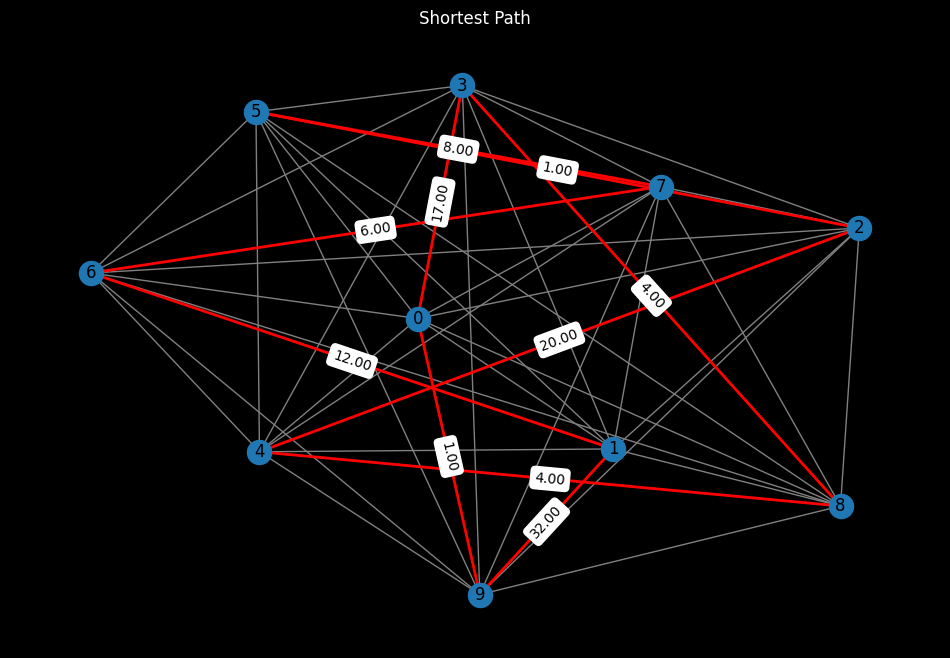

In [6]:
# Plot the shortest path
plot_shortest_path(distances, best_path)